<a href="https://colab.research.google.com/github/nvinogradskaya/Geolife/blob/main/Contrastive%2BLSTM-v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 538.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 93.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import os
import tensorflow as tf
import pandas as pd
import uuid
import shutil
import matplotlib.pyplot as plt
import pickle

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Dropout, LayerNormalization
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
import time

In [3]:
from google.colab import drive
drive.mount('/content/drive')

MAX_USERS = 170
SEQ_LENGTH = 10
EMBEDDING_DIM = 16
LSTM_UNITS = 64
BATCH_SIZE = 128
EPOCHS = 20
TEST_SIZE = 0.3

DATA_PATH = "/content/drive/My Drive/Colab Notebooks/Data/"
SAVE_PATH = "/content/drive/My Drive/Colab Notebooks/contrastive_results-v5-1/"
SEQ_SAVE_PATH = os.path.join(SAVE_PATH, 'sequences/')
os.makedirs(SAVE_PATH, exist_ok=True)
os.makedirs(SEQ_SAVE_PATH, exist_ok=True)

Mounted at /content/drive


In [4]:
from tqdm import tqdm
def load_and_preprocess_data(data_path, max_users=MAX_USERS):
    data = []
    user_dirs = sorted(os.listdir(data_path))[:max_users]
    for user in tqdm(user_dirs, desc="Loading users"):
        traj_dir = os.path.join(data_path, user, 'Trajectory')
        traj_files = sorted([f for f in os.listdir(traj_dir) if f.endswith('.plt')])
        for traj_file in traj_files:
            df = pd.read_csv(
                os.path.join(traj_dir, traj_file),
                skiprows=6,
                header=None,
                usecols=[0, 1, 3, 5, 6],
                names=['lat', 'lon', 'alt', 'date', 'time']
            )
            df['user'] = user
            data.append(df)

    df = pd.concat(data, ignore_index=True)
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
    df.sort_values(by=['user', 'datetime'], inplace=True)
    df = df[(df['lat'] != 0) & (df['lon'] != 0)].ffill()

    scaler = MinMaxScaler()
    df[['lat', 'lon', 'alt']] = scaler.fit_transform(df[['lat', 'lon', 'alt']])

    df['hour_sin'] = np.sin(2 * np.pi * df['datetime'].dt.hour / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['datetime'].dt.hour / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['datetime'].dt.dayofweek / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['datetime'].dt.dayofweek / 7)

    user_ids = {user: idx for idx, user in enumerate(df['user'].unique())}
    df['user_id'] = df['user'].map(user_ids)

    return df, user_ids, scaler

In [5]:
df, user_ids, scaler = load_and_preprocess_data(DATA_PATH)

Loading users: 100%|██████████| 170/170 [27:15<00:00,  9.62s/it]


In [6]:
def create_sequences_and_save(df, user_ids, seq_length, test_size=0.3, save_path='./seq_data'):
    os.makedirs(save_path, exist_ok=True)
    features = ['lat', 'lon', 'alt', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos']
    targets = ['lat', 'lon']

    for user, user_df in tqdm(df.groupby('user'), desc="Creating sequences"):
        uid = user_ids[user]
        user_df = user_df.reset_index(drop=True)
        split_idx = int(len(user_df) * (1 - test_size))
        if split_idx <= seq_length:
            continue

        def process_chunk(data, is_train=True):
            window_size = seq_length + 1
            data_values = data[features].values
            if len(data_values) < window_size:
                return
            X = np.lib.stride_tricks.sliding_window_view(data_values, (window_size, data_values.shape[1])).squeeze(axis=1)
            X = X[:, :-1]
            y = data[targets].values[seq_length:]
            chunk_size = 1000
            for i in range(0, len(X), chunk_size):
                save_chunk(X[i:i+chunk_size], y[i:i+chunk_size], is_train)

        def save_chunk(X, y, is_train):
            suffix = 'train' if is_train else 'test'
            chunk_id = uuid.uuid4().hex
            np.savez_compressed(
                os.path.join(save_path, f'user_{uid}_{suffix}_{chunk_id}.npz'),
                X=X,
                y=y,
                user_id=uid
            )

        process_chunk(user_df.iloc[:split_idx], is_train=True)
        process_chunk(user_df.iloc[split_idx-seq_length:], is_train=False)

In [7]:
shutil.rmtree(SEQ_SAVE_PATH, ignore_errors=True)
os.makedirs(SEQ_SAVE_PATH, exist_ok=True)
create_sequences_and_save(df, user_ids, SEQ_LENGTH, save_path=SEQ_SAVE_PATH)

Creating sequences: 100%|██████████| 170/170 [04:36<00:00,  1.63s/it]


In [8]:
def load_all_sequences_from_disk(save_path):
    X_train, X_test, y_train, y_test, users_train, users_test = [], [], [], [], [], []
    for fname in tqdm(sorted(os.listdir(save_path)), desc="Loading sequences"):
        if not fname.endswith('.npz'):
            continue
        split_type = 'train' if 'train' in fname else 'test'
        uid = int(fname.split('_')[1])
        data = np.load(os.path.join(save_path, fname))
        X, y = data['X'], data['y']
        if split_type == 'train':
            X_train.append(X); y_train.append(y); users_train.append(np.full(len(X), uid))
        else:
            X_test.append(X); y_test.append(y); users_test.append(np.full(len(X), uid))
    return (
        np.concatenate(X_train), np.concatenate(X_test),
        np.concatenate(y_train), np.concatenate(y_test),
        np.concatenate(users_train), np.concatenate(users_test)
    )

In [9]:
X_train, X_test, y_train, y_test, users_train, users_test = load_all_sequences_from_disk(SEQ_SAVE_PATH)

Loading sequences: 100%|██████████| 24790/24790 [04:38<00:00, 88.88it/s] 


In [10]:
def create_triplets(X, user_ids):
    anchors, positives, negatives = [], [], []
    for uid in tqdm(np.unique(user_ids), desc="Creating triplets"):
        same_user_idx = np.where(user_ids == uid)[0]
        diff_user_idx = np.where(user_ids != uid)[0]
        if len(same_user_idx) < 2:
            continue
        for i in range(min(len(same_user_idx) - 1, 100)):
            a_idx, p_idx = same_user_idx[i], same_user_idx[i+1]
            n_idx = np.random.choice(diff_user_idx)
            anchors.append(X[a_idx])
            positives.append(X[p_idx])
            negatives.append(X[n_idx])
    return np.array(anchors), np.array(positives), np.array(negatives)

In [11]:
anchors, positives, negatives = create_triplets(X_train, users_train)

Creating triplets: 100%|██████████| 170/170 [00:08<00:00, 19.76it/s]


In [12]:
def contrastive_model(input_shape, embedding_dim):
    inp = Input(shape=input_shape)
    x = LSTM(32)(inp)
    x = Dense(embedding_dim)(x)
    model = Model(inputs=inp, outputs=x)
    return model

def triplet_loss_fn(a, p, n, margin=1.0):
    ap_dist = tf.reduce_sum(tf.square(a - p), axis=1)
    an_dist = tf.reduce_sum(tf.square(a - n), axis=1)
    return tf.reduce_mean(tf.maximum(ap_dist - an_dist + margin, 0.0))

In [13]:
triplet_encoder = contrastive_model(X_train.shape[1:], EMBEDDING_DIM)
optimizer = tf.keras.optimizers.Adam(1e-3)

In [14]:
for epoch in range(20):
    with tf.GradientTape() as tape:
        emb_a = triplet_encoder(anchors)
        emb_p = triplet_encoder(positives)
        emb_n = triplet_encoder(negatives)
        loss = triplet_loss_fn(emb_a, emb_p, emb_n)
    grads = tape.gradient(loss, triplet_encoder.trainable_variables)
    optimizer.apply_gradients(zip(grads, triplet_encoder.trainable_variables))
    print(f"сontrastive epoch {epoch+1} // loss = {loss.numpy():.4f}")

сontrastive epoch 1 // loss = 0.2377
сontrastive epoch 2 // loss = 0.2150
сontrastive epoch 3 // loss = 0.1958
сontrastive epoch 4 // loss = 0.1790
сontrastive epoch 5 // loss = 0.1640
сontrastive epoch 6 // loss = 0.1504
сontrastive epoch 7 // loss = 0.1381
сontrastive epoch 8 // loss = 0.1269
сontrastive epoch 9 // loss = 0.1168
сontrastive epoch 10 // loss = 0.1078
сontrastive epoch 11 // loss = 0.0998
сontrastive epoch 12 // loss = 0.0925
сontrastive epoch 13 // loss = 0.0861
сontrastive epoch 14 // loss = 0.0804
сontrastive epoch 15 // loss = 0.0754
сontrastive epoch 16 // loss = 0.0710
сontrastive epoch 17 // loss = 0.0669
сontrastive epoch 18 // loss = 0.0632
сontrastive epoch 19 // loss = 0.0598
сontrastive epoch 20 // loss = 0.0567


In [15]:
user_embeddings_matrix = {}
batch_size = 1024

for uid in np.unique(users_train):
    user_seqs = X_train[users_train == uid]
    user_embs = []

    for i in range(0, len(user_seqs), batch_size):
        batch = user_seqs[i:i+batch_size]
        batch_embs = triplet_encoder(batch)
        user_embs.append(batch_embs.numpy())

    user_embs = np.concatenate(user_embs, axis=0)
    user_embeddings_matrix[uid] = np.mean(user_embs, axis=0)

user_embeddings_train = np.array([user_embeddings_matrix[uid] for uid in users_train])
user_embeddings_test = np.array([user_embeddings_matrix[uid] for uid in users_test])

In [16]:
class CombinedDataGenerator(Sequence):
    def __init__(self, X, user_embeddings, y, batch_size=64):
        self.X = X
        self.user_embeddings = user_embeddings
        self.y = y
        self.batch_size = batch_size
        self.indices = np.arange(len(self.X))

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = min((index + 1) * self.batch_size, len(self.X))

        X_batch = self.X[start:end]
        user_batch = self.user_embeddings[start:end]
        y_batch = self.y[start:end]

        return (X_batch, user_batch), y_batch

    def on_epoch_end(self):
        pass

In [17]:
def build_lstm_model(seq_input_shape, user_input_shape):

    seq_input = Input(shape=seq_input_shape, name='seq_input')
    x = LSTM(LSTM_UNITS, return_sequences=False)(seq_input)
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)

    user_input = Input(shape=user_input_shape, name='user_input')
    user_dense = Dense(16, activation='relu')(user_input)

    combined = Concatenate()([x, user_dense])

    output = Dense(2, activation='linear')(combined)

    model = Model(inputs=[seq_input, user_input], outputs=output)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [18]:

train_gen = CombinedDataGenerator(X_train, user_embeddings_train, y_train, batch_size=BATCH_SIZE)
val_gen = CombinedDataGenerator(X_test, user_embeddings_test, y_test, batch_size=BATCH_SIZE)

seq_input_shape = (X_train.shape[1], X_train.shape[2])
user_input_shape = (EMBEDDING_DIM,)

model = build_lstm_model(seq_input_shape, user_input_shape)


In [19]:
callbacks = [
    ModelCheckpoint(os.path.join(SAVE_PATH, 'best_model.keras'), save_best_only=True, monitor='val_loss'),
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]
print("\nОбучение модели")
start_train = time.time()
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)
train_time = time.time() - start_train
print(f"Время обучения: {train_time:.2f} сек")


Обучение модели
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


134655/134655 ━━━━━━━━━━━━━━━━━━━━ 1493s 11ms/step - loss: 0.0065 - mae: 0.0207 - val_loss: 5.3416e-05 - val_mae: 0.0048
Epoch 2/20
134655/134655 ━━━━━━━━━━━━━━━━━━━━ 1481s 11ms/step - loss: 1.0365e-04 - mae: 0.0053 - val_loss: 6.4789e-05 - val_mae: 0.0056
Epoch 3/20
134655/134655 ━━━━━━━━━━━━━━━━━━━━ 1447s 11ms/step - loss: 6.4641e-05 - mae: 0.0037 - val_loss: 1.2537e-05 - val_mae: 0.0015
Epoch 4/20
134655/134655 ━━━━━━━━━━━━━━━━━━━━ 1445s 11ms/step - loss: 5.8552e-05 - mae: 0.0033 - val_loss: 1.3193e-05 - val_mae: 0.0016
Epoch 5/20
134655/134655 ━━━━━━━━━━━━━━━━━━━━ 1466s 11ms/step - loss: 6.6074e-05 - mae: 0.0033 - val_loss: 4.8007e-05 - val_mae: 0.0029
Epoch 6/20
134655/134655 ━━━━━━━━━━━━━━━━━━━━ 1481s 11ms/step - loss: 6.6984e-05 - mae: 0.0034 - val_loss: 7.4908e-06 - val_mae: 0.0012
Epoch 7/20
134655/134655 ━━━━━━━━━━━━━━━━━━━━ 1462s 11ms/step - loss: 4.7854e-05 - mae: 0.0029 - val_loss: 4.9102e-06 - val_mae: 0.0017
Epoch 8/20
134655/134655 ━━━━━━━━━━━━━━━━━━━━ 1438s 11ms/step -

In [20]:
model.load_weights(os.path.join(SAVE_PATH, 'best_model.keras'))
def predict_with_generator(model, X, user_embs, batch_size=64, save_path=None, verbose=False, max_errors=3):
    generator = CombinedDataGenerator(
        X, user_embs, np.zeros((len(user_embs), 2)),
        batch_size=batch_size
    )

    preds = []
    error_count = 0
    suppressed = False

    for i, (X_batch, _) in enumerate(tqdm(generator, total=len(generator), desc="Predicting", disable=not verbose)):
        try:
            if X_batch[0].shape[0] == 0:
                continue

            batch_pred = model.predict(X_batch, verbose=0)
            preds.append(batch_pred)


        except Exception as e:
            if error_count < max_errors:
                print(f"err {i}: {e}")
            elif error_count == max_errors and not suppressed:
                print("err")
                suppressed = True
            error_count += 1
            continue

    if preds:
        result = np.vstack(preds)
        return result
    else:
        if verbose:
            print("nulls")
        return np.empty((0, 2))

In [21]:
#y_pred = predict_with_generator(model, X_test, user_embeddings_test, save_path=os.path.join(SAVE_PATH, "y_pred"))
dataset = tf.data.Dataset.from_tensor_slices(((X_test, user_embeddings_test), y_test))
dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
start_time = time.time()
y_pred = model.predict(dataset)
inference_time = time.time() - start_time
total_samples = len(y_test)
samples_per_sec = total_samples / inference_time

57716/57716 ━━━━━━━━━━━━━━━━━━━━ 225s 4ms/step


In [25]:
def calculate_metrics(preds, targets, inference_time, total_samples):
    errors_meters = np.linalg.norm(preds - targets, axis=-1)
    lat_errors = np.abs(preds[:, 0] - targets[:, 0])
    lon_errors = np.abs(preds[:, 1] - targets[:, 1])

    mae_lat = np.mean(lat_errors)
    mae_lon = np.mean(lon_errors)
    total_mae_avg = (mae_lat + mae_lon) / 2

    metrics = {
        'MAE Latitude': mae_lat,
        'MAE Longitude': mae_lon,
        'Total MAE (avg)': total_mae_avg,
        'ADE': np.mean(errors_meters),
        'FDE': errors_meters[-1],
        'Median Error': np.median(errors_meters),
        '95th Percentile': np.percentile(errors_meters, 95),
        'RMSE': np.sqrt(np.mean(errors_meters**2)),
        'Max Error': np.max(errors_meters),
        'Inference Time': f"{inference_time:.2f} сек",
        'Throughput': f"{total_samples/inference_time:.1f} samples/sec"
    }

    for name, value in metrics.items():
        if name in ['Inference Time', 'Throughput']:
            print(f"{name}: {value}")
        else:
            unit = "°" if "Latitude" in name or "Longitude" in name else " "
            print(f"{name}: {value:.6f}{unit}")

    return metrics

In [26]:
metrics = calculate_metrics(y_pred, y_test, inference_time, total_samples)

MAE Latitude: 0.000598°
MAE Longitude: 0.000715°
Total MAE (avg): 0.000656 
ADE: 0.000992 
FDE: 0.000675 
Median Error: 0.000648 
95th Percentile: 0.003650 
RMSE: 0.001842 
Max Error: 0.662911 
Inference Time: 251.97 сек
Throughput: 29319.4 samples/sec


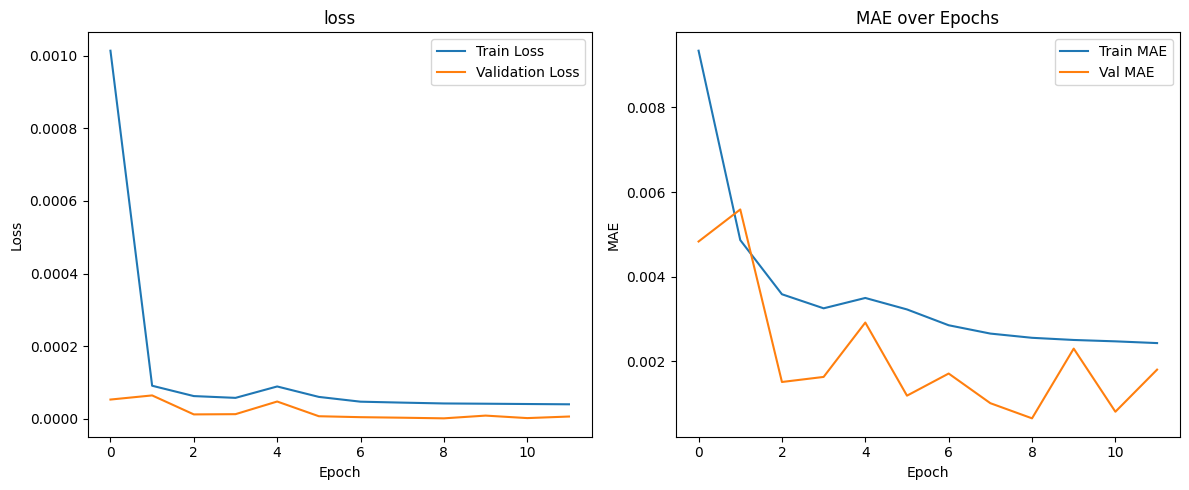

In [28]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.title('MAE over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)